# Monte-Carlo and Finite Difference
## American Options

In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import scipy.stats as st
from scipy.optimize import curve_fit
from mpl_toolkits.mplot3d import Axes3D
from scipy.sparse import diags
from matplotlib import cm
from tqdm import tqdm
from scipy.stats import norm

log = np.log 
exp = np.exp 
sqrt = np.sqrt
ncdf = norm.cdf

In [2]:
# Financial data 
S0 = 100 # Initial underlying price
r_input = 0.06 # Risk-free rate
sigma = 0.4 # Volatility
K = 100 # Strike
T = 0.5 # Maturity


# Numerical data 
MC = 1000 # Number of paths
m = 1à0 # Number of time steps
t = np.linspace(0,T,m+1)[np.newaxis,:] # Corresponding time grid

### abstract

This project is part of the evaluation of the course "Monte Carlo and Finite Difference" of the MASEF (ex DEA-MASE) of the University Paris Dauphine. The objective is to use the knowledge acquired during the course to understand a corpus of scientific articles, to be able to understand and reproduce the reasoning and algorithms described there. Our choice of subject is the pricing of American options and this choice is not innocuous as it also allows us to link elements seen during the course "Stochastic Control".           
Therefore we will in this project explain what is an american option, the difficulty linked to its pricing, how it can be overcame and we will even go further by studying other properties of american options. The first section deals with how it can be priced through Monte-Carlo, finding a lower and an upper bound of the price. The second sections deals with how it can be priced through PDE, numerical schemes involved and how we can compute greeks.

* Introduction
* pricing by Monte-Carlo
     + context
     + lower bound 
         + The problem
         + The Longstaff Schwartz Algorithm
     + upper bound 
         + The dual problem
         + Constructing the good martingale 
* Pricing by PDE 
    + General Stuff
        + Context, PDE and stuff like this
        + Well Posed PDE
    + Numerical methods
        + General numerical stuff
        + Implicit Scheme
        + Pricing of an american put
        + error of the scheme
        + (BONUS) Proposition for a better solver 
            + (BONUS) LU and SOR 
            + (BONUS) Richardson extrapolation
    + (BONUS) The impact of interest rates 
        + (BONUS) Evolution of the price with different interest rates : european vs US PUT option
        + (BONUS) Continuation and stopping region
    + (BONUS) Greeks
        + (BONUS) Delta 
        + (BONUS) Gamma
* Conclusion

### Introduction

On financial markets there exist special contracts entitled : options. Those contracts give the right (not the obligation) to the holder to exercise the contract.         
These contracts can be divided in two big families, european and american options. The difference between those two is that for european options, the holder can only exercise its right at the maturity of the option whereas for american options, the holder can exercise his right at any time prior to the maturity. This simple difference leads to many difficulty in the pricing of such contracts. In this project we will see methods to price an american option by probabilistic method (and get a good confidence interval) as well as deterministic methods. A big part of the probabilistic method is due to L. C. G. Rogers as he gives a dual formulation of the pricing of the american option. For the PDE part, we will focus on numerical schemes and the difference between pricing an european option and it's american counterpart. Finally We will as well calculate the greeks : Delta and Gamma. 

### I - Pricing by Monte-Carlo

#### I.1 - Context

T > 0 time horizon         
$\left( \Omega, \mathcal{F}, \left( \mathcal{F}_t \right)_{0 \leq t \leq T}, \mathbb{P} \right)$ filtered space
Suppose that the market is complete etc. unique martingale equivalent measure $\mathbb{Q}$          
$r_t$ the adapted process for the interest rate. It will be supposed to be deterministic      
$S_t$ is the price of the underlying which is the solution of the following SDE : 
$$
\begin{align*}
    dS_t &= S_t \left( r dt + \sigma dW_t \right) \\
    S_{t_0} &= x
\end{align*}
$$
In fact S_t can even be : $S_t = \left( S_t^1 , ... , S_t^{d} \right)$ if the product depends on d assets       
We will also is the following flow notation : $S_t = S_t^{t_0, x_0}$        
$\tilde{Z}_t$ the adapted process entitled the reward process also called payoff. The reward process is generally a function of the underlying asset $S_t$, i.e : $\tilde{Z}_t = f(S_t)$. There can be much more parameters and here $(S_t)$ can live in any dimension.         
$Z_t = \exp \left( - \int_{0}^{t} r_s ds \right) \tilde{Z}_t$ the discounted exercise value of the option.         
....      
An american option is an option that gives the right to the holder to excerise the option at any time prior to the maturity. Therefore this kind of options is more flexible than their european counterparts as one can exerce before the maturity. let's denote by $v(t,x)$ the price of an american option at time **t** and $\bf{S_t = x}$ :
$$
\begin{equation}
    v(t,x) = \underset{\tau \in \mathcal{T}_t}{essup} \left( \mathbb{E}^{\mathbb{Q}} \left[ Z_{\tau} \middle| \mathcal{F}_t \right] \right)
\end{equation}
$$
Where $\mathcal{T}_t$ denotes the set of stopping times with values in $[t;T]$

Defined like this, the family $(v(t,.))_{t \in [0,t]}$ is called the snell-eveloppe of the process $(Z_t)_{t \in [0,T]}$

#### I.2 - Lower-Bound

##### I.2.1 - The problem

First of all, as we are dealing with numerical methods, we will have to discretize the time interval, i.e : define $(t_i)_{0 \leq i \leq m}$ such that : $0 = t_0 < t_1 < ... < t_m = T$      

One may remark that by doing so, we can only obtain a lower bound (i.e : suboptimal value) of the true price of an american option. Indeed as the sup is only in $[t_0, t_1, .. , t_m]$ sup dans sup t'as capté .... (need to better explain this)        
As stated in **Glasserman's book** (Monte Carlo methods in financial engineering) the price of an american option as the following dynamic programming equation : 
$$
\begin{align*}
    \tilde{v}(t_m,x) &= \tilde{Z}_{t_m} \\
    \tilde{v}(t_{i-1},x) &= \max \left( \tilde{Z}_{t_i} \text{ , } \mathbb{E} \left[ D_{i-1,i} \tilde{v} \left( t_i, S_{t_i}^{t_{i-1}, x } \right) \middle| S_{t_{i-1}} = x  \right] \right) \quad \forall i \in [1,m]
\end{align*}
$$
where : 
- $D_{i-1,i} = \exp \left( - \int_{t_{i-1}}^{t_i} r_s ds \right)$      
If $r$ is constant and the time discretization is such that $t_i = i\frac{T}{m} = i h$ then we can call the discount factor over one period $D$ and $D = \exp \left( -r h \right)$       
Thus we have a backward formulation of the problem.         
The dynamic programming formulation see the option pricing problem as finding the right value but it's the same as finding the good stopping rule (i.e a stopping time $\tau$ such that $v(t,x) = \mathbb{E} \left[ \tilde{Z}_{\tau} \middle| \mathcal{F_t} \right]$ 

##### I.2.2 - The Longstaff Schwartz  algorithm

The longstaff Schwartz algorithm is a regression based method. Indeed (continue explanation)

basis functions used here :
$$
\begin{align*}
    f_1 &: x \rightarrow 1 \\
    f_2 &: x \rightarrow x \\
    f_3 &: x \rightarrow x^2 
\end{align*}
$$

In [3]:
# Longstaff-Schwartz regression basis 
basis1 = lambda x : 1
basis2 = lambda x : x
basis3 = lambda x : x**2

f = lambda x,alpha1,alpha2,alpha3 : alpha1*basis1(x) + alpha2*basis2(x) + alpha3*basis3(x) # Longstaff-Schwartz regression function

We want to find $\alpha_1, \alpha_2, \alpha_3$ such that for $f$ defined as :
$$
\begin{equation*}
f : x \rightarrow \alpha_1 + \alpha_2 x + \alpha_3 x^{2}
\end{equation*}
$$
can be used such that : $f(S_{t_{k}})$ is a good approximation of : $ \mathbb{E} \left[ v(t_{k+1}, S_{t_{k+1}}) | S_{t_k} \right] $ 
$$
\begin{equation*}
    \mathbb{E} \left[ v(t_{k+1}, S_{t_{k+1}}) | S_{t_k} \right] \approx f(S_{t_{k}}) = \alpha_1 + \alpha_2 S_{t_k} + \alpha_3 S_{t_k}^{2}
\end{equation*}
$$

In [4]:
# d rows and N columns
def brownian_motion(T : float,N : int,d : int):
    if d == 1:
        return(np.insert(np.random.normal(scale = sqrt(T/N), size = N).cumsum(), 0, 0))
    elif d > 1:
        return(np.insert(np.random.normal(scale = sqrt(T/N), size = (d,N)).cumsum(axis = 1), 0, 0, axis = 1))

In [5]:
payoff_call = lambda x,K : (x-K)*(x-K >=0)
payoff_put = lambda x,K : (K-x)*(K-x >=0)
BS_process = lambda x0,r,sigma,t,W : x0*np.exp( (r- (sigma**2)/2)*t + sigma*W ) 
D = lambda X , t , r=r_input : X*exp(-r*t) # Discounting X from time 0 to time t

In [6]:
W = brownian_motion(T,m,MC)
S = BS_process(S0,r_input,sigma,t,W) #St[i] gives the i-th trajectory therefore St[i,k] = S_{t_k}^{i}

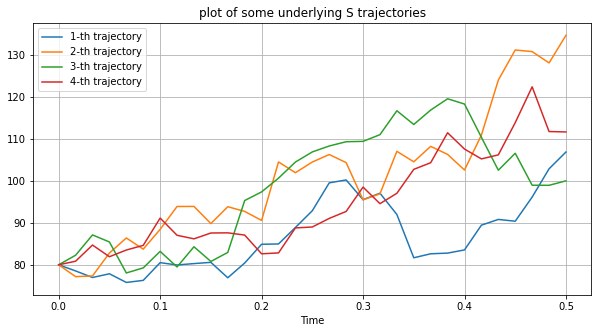

In [7]:
plt.subplots(figsize=(10,5))

for i in range(4):
    plt.plot(t[0],S[i], label = "{}-th trajectory".format(i+1))

plt.xlabel("Time") ; plt.title("plot of some underlying S trajectories")
plt.grid() ; plt.legend()
plt.show()

In [8]:
def LongStaff(S0 = S0, r = r_input, sigma = sigma, K = K, T = T, payoff = payoff_put, f = f, m = m, MC = MC):
    t = np.linspace(0,T,m+1)
    #m = len(t[0])
    D = np.exp(-r*(T/m))
    W = brownian_motion(T,m,MC)
    S = BS_process(S0,r,sigma,t,W) #St[i] gives the i-th trajectory therefore St[i,k] = S_{t_k}^{i}
    
    V = np.zeros(S.shape)
    V[:,-1] = payoff(S[:,-1],K) #the terminal value can only be the payoff of the option
    alphas = []
    for i in tqdm(range(m-1,0,-1)): # loop backward in time
        alpha, _ = curve_fit(f,xdata = S[:,i] ,ydata = V[:,i+1]) # y_{data} = f(x_{data}) + \varepsilon
        alphas.append(alpha)

        for j in range(MC-1,-1,-1): #loop in sample paths
            if (payoff(S[j,i],K) >= D*f(S[j,i],alpha[0],alpha[1],alpha[2])) :
                V[j,i] = payoff(S[j,i],K)
            else:
                V[j,i] = D*V[j,i+1] 
    V0 = max(payoff(S0,K), D*V[:,1].mean())
    return V0, alphas[::-1] 

In [9]:
V0_arr = np.zeros(10)
for i in tqdm(range(len(V0_arr))):
    V0_arr[i], alphas = LongStaff(S0=S0, K =K,r = r_input, T = T, sigma = sigma, payoff = payoff_put, m = m, MC = MC)
        
price = V0_arr.mean()
std = np.std(V0_arr)
IC = [price-1.96*std/sqrt(MC),price+1.96*std/sqrt(MC)]
print("Longstaff | The value of the option is : {} with IC = {}".format(price,IC))

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.91it/s]

Longstaff | The value of the option is : 21.435011011375984 with IC = [21.415629421201317, 21.45439260155065]


##### I.3.1 - The dual problem 

The methods seen earlier can only produce a lower bound. Which can be an issue because even if the the method converges toward the real price (if the time step goes to $0$ and the number and sample paths goes to $+ \infty$) it still converges by below so it's an issue if we want a proper confidence interval for the **true** price. Therefore we need to consider other methods.          
First of all one can see that what we are dealing with is an optimisation problem. Indeed the problem considered can be seen as the primal. One could thus think of the dual problem.

The dual problem is the following : 
$$
\begin{equation}
    v(t,x) = \underset{M \in H^1_0}{essinf} \left( \mathbb{E}^{\mathbb{Q}} \left[ \underset{0 \leq s \leq T}{sup} \left( Z_s - M_ts \right) \middle| \mathcal{F}_t \right] \right)
\end{equation}
$$

Where $H^1_0$ is the following set : 
$$
\begin{equation}
    H^1_0 = \left\{ M \text{ martingale s.t ,} \sup \left( M_t \right) < + \infty \text{ and } M_0 = 0 \right\} 
\end{equation}
$$

**proof :**        
Let $M \in H^1_0$
$$
\begin{align*}
    v(t,x) &= \underset{\tau \in \mathcal{T}_t}{essup} \left( \mathbb{E}^{\mathbb{Q}} \left[ Z_{\tau} \middle| \mathcal{F}_t \right] \right) \\
    &= \underset{\tau \in \mathcal{T}_t}{essup} \left( \mathbb{E}^{\mathbb{Q}} \left[ Z_{\tau} + M_{\tau} - M_{\tau} \middle| \mathcal{F}_t \right] \right) \\
    &= \underset{\tau \in \mathcal{T}_t}{essup} \left( \mathbb{E}^{\mathbb{Q}} \left[ Z_{\tau}  - M_{\tau} \middle| \mathcal{F}_t \right] + \mathbb{E}^{\mathbb{Q}} \left[  M_{\tau} \middle| \mathcal{F}_t \right] \right) \\
    &= \underset{\tau \in \mathcal{T}_t}{essup} \left( \mathbb{E}^{\mathbb{Q}} \left[ Z_{\tau}  - M_{\tau} \middle| \mathcal{F}_t \right] + M_0 \right) \quad \left( M_t \right)_{0 \leq t \leq T} \text{ est une martingale}\\
    &= \underset{\tau \in \mathcal{T}_t}{essup} \left( \mathbb{E}^{\mathbb{Q}} \left[ Z_{\tau}  - M_{\tau} \middle| \mathcal{F}_t \right] \right) \quad M_0 = 0\\
    &\leq \mathbb{E}^{\mathbb{Q}} \left[ \underset{\tau \in \mathcal{T}_t}{\sup} \left( Z_{\tau}  - M_{\tau} \right) \middle| \mathcal{F}_t \right] \\
\end{align*}
$$
next is ...

#### I.3 - Example

### American option pricing by Rogers method

In [2053]:
def european_put(S, r=r_input, sigma=sigma, K=K, t=t):
    '''
    Pricing a European put along times t over underlying trajectories S

    S : (MC,m+1) array of underlying trajectories
    r : risk-free rate
    sigma : volatility
    K : strike
    t : (1,m+1) time array 

    output : (MC,m+1) array of analytical European put prices
    '''
    t[:,-1] -= 10e-15 # Silencing div. by zero warning
    d1 = ( log(S/K) + (r + sigma**2/2)*(T-t) ) / (sigma*sqrt(T-t))
    d2 = d1 - sigma*sqrt(T-t) 
    return K*exp(-r*(T-t))*ncdf(-d2) - S*ncdf(-d1) 


def rogers(N, S=S, r=r_input, sigma=sigma, K=K, t=t):
    '''
    Compute N times Rogers upper bound on the price of an American put option

    S : (MC,m+1) array of underlying trajectories
    r : risk-free rate
    sigma : volatility
    K : strike
    t : (1,m+1) time array

    output : dictionnary with bounds and associated mean and std
    '''
    s0 = S[0,0]
    MC = S.shape[0] # Number of paths
    m = S.shape[1]-1 # Number of time steps
    R = np.empty((N,1)) # Upper bounds
    t = np.linspace(0,T,m+1)[np.newaxis,:] 

    for i in tqdm(range(N), desc='Rogers upper bounds'):
        W = brownian_motion(T,m,MC) 
        S = BS_process(s0,r_input,sigma,t,W) 

        Z = D(payoff_put(S,K),t) # Discounted payoffs
        M = D(european_put(S),t) # Discounted European put prices

        sups = np.max( Z-(M-M[0,0]), axis=1) # Shifting martingale so that it starts at 0
        mc_sup = sups.mean() 
        R[i] = mc_sup

    return {'bounds' : R, 'mean' : R.mean(), 'std' : R.std(), 'mad' : np.abs(R-R.mean()).mean() }


In [2047]:
R = rogers(100)
print(f'Rogers upper bound : {R["mean"]:.4f} +/- {1.96*R["std"]/sqrt(100):.4f}, MAD = {R["mad"]:.4f}')

Rogers upper bounds: 100%|██████████| 100/100 [00:23<00:00,  4.21it/s]

Rogers upper bound : 21.8243 +/- 0.0006, MAD = 0.0022


### American option pricing by Andersen-Broadie method

In [1773]:
def LS_region(slice, step, alphas):
    '''
    Compute LS-estimated continuation value of a list
    ___________________________________________________________________________
    slice : list of underlying values at time 'step'
    step : time step
    alphas : list of LS alphas parameters
    '''
    alpha = alphas[step]
    B = np.zeros(len(slice))

    for i in range(len(slice)-1):
        B[i] = f(slice[i] , *alpha)
    B[-1] = payoff_put(S0,K)
    return B

In [1900]:
def cond_exp(step, t, s0, K=K, alphas=alphas, N=100):
    '''
    Estimate the conditional expectation of the discounted payoff of an
    American put option issued at time t[step], given the underlying is at s0,
    following a strategy based on the exer£cise boundary B.
    ___________________________________________________________________________
    step : time step at which the option is issued
    t : (1,m+1) time array
    s0 : starting point of the underlying
    K : strike
    B : (1,m+1) array of exercise boundaries
    N : number of paths to simulate
    ___________________________________________________________________________
    output : conditional expectation of the discounted payoff
    '''

    sub_S = np.stack([s0]*N) # Starting point the paths to come 
    payoffs = np.empty(N) # Payoffs of the paths to come
    cont = np.arange(N) # Indexes of the paths to be continued
    j = step + 1 # time index 

    while j<len(t) and cont.any()==True: # While there are remain active paths and time steps 
        sub_S[cont] = BS_process(sub_S[cont],r_input,sigma,t[1],brownian_motion(t[1], 1, 1)[-1]) # Simulate paths one step further
        ex_ind = np.where( (LS_region(sub_S[cont],j,alphas) < payoff_put(sub_S[cont],K)) == 1 )[0] # Get indexes of paths that need to be exercised
        payoffs[cont[ex_ind]] = payoff_put(sub_S[cont[ex_ind]],K) # Update payoffs 
        cont = cont[~ex_ind] # Remove exercised paths 
        j+=1
    
    return payoffs.mean()


In [1918]:
def andersen_broadie(B=B, S=S, r=r_input, sigma=sigma, K=K, t=t, N1=100, N2=100):
    '''
    Compute Andersen-Broadie upper bound on the price of an American put option
    ___________________________________________________________________________
    B : (1,m+1) array of exercise boundaries
    S : (MC,m+1) array of underlying trajectories
    r : risk-free rate
    sigma : volatility
    K : strike
    t : (1,m+1) time array
    ___________________________________________________________________________
    output : Andersen & Broadie upper bound for american put options
    '''

    V = np.empty_like(S) # Discounted value of the option
    EV = np.empty_like(S) # Expected discounted value of the option
    V[:,0] = S[:,0] # Initial value of the option is the initial value of the underlying
    EV[:,0] = S[:,0] # Initial value of the option is the initial value of the underlying
    _, alphas = LongStaff(S[0,0], r=r_input, sigma=sigma, K=K, T=t[-1], m=m, MC=MC)

    for step in range(len(t)): # We get cross-path slices at each time step
        print(f'\nTIME :  {step}')
        path_slice = S[:,step] # Cross-paths slice of underlying trajectories at time t
        value_slice = V[:,step]
        ex_slice = LS_region(path_slice,step,alphas) < payoff_put(path_slice,K) # True if payoff is higher than expected LS-optimal future earnings

        # Continued paths
        cont_idx = np.where(ex_slice==0)[0]
        print(f'cont_idx = {cont_idx}')
        for i in cont_idx: 
            EV[step,i]  = cond_exp(step, t, path_slice[i], alphas=alphas, N=N1)
            value_slice[i] = EV[step,i]

        # Exercised paths
        ex_ind = np.where(ex_slice==1)[0]
        print(f'ex_ind : {ex_ind}')
        for i in ex_ind: 
            print(f'value_slice shape : {value_slice[i].shape}')
            print(f' p shape : {value_slice[i].shape}')
            value_slice[i] = D(payoff_put(path_slice[i],K) , t) # Set discounted payoff as new value
            EV[step,i] = cond_exp(step, t, path_slice[i], N=N2) # Update expected value

    pi = np.zeros(S.shape)
    pi[:1] = (V[:,1:]- EV[:,:-1]).cumsum(axis=0) # We sum martingale increments 

    maxs = ( D(payoff_put(S,K),t)- pi ).max(axis=0)
    return maxs.mean()